In [1]:
%pip install qiskit

Note: you may need to restart the kernel to use updated packages.


In [2]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, AncillaRegister
from qiskit.quantum_info import Statevector, Operator

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

# preparations

In [6]:
def ModifiedWalshHadamard(f):
    f = np.array(f)

    n, d = int(np.ceil(np.log2(f.shape[0]))), int(np.ceil(np.log2(max(max(f) + 1, - min(f))))) + 1
    A = np.arange(1 << n, dtype=int)

    phases = np.pad(f, (0, (1 << n) - f.shape[0]))

    for idx in range(1, n + 1):
        A = A.reshape((1 << idx, 1 << (n - idx)))
        x, y = A[::2,:].flatten(), A[1::2,:].flatten()
        phases[[x, y]] = phases[x] + phases[y], phases[x] - phases[y]

    return np.pi * phases.reshape((- 1, 1)) / ((1 << n) << np.arange(d)), n, d #np.pi * np.mod(phases.reshape((- 1, 1)) / (1 << np.arange(n + d)), 2), n, d

In [7]:
def QuantumFourierTransform(d):
    qreg = AncillaRegister(d, "y")
    qft_circ = QuantumCircuit(qreg, name=f"QFT")

    for i, q in enumerate(qreg, start=1):
        qft_circ.h(q)
        for j, p in enumerate(qreg[i:], start=1):
            qft_circ.cp(np.pi / (1 << j), q, p)

    for q, p in zip(qreg[:d//2], reversed(qreg[d//2:])):
        qft_circ.swap(q, p)

    return qft_circ

def InverseQuantumFourierTransform(d):
    qreg = AncillaRegister(d, "y")
    iqft_circ = QuantumCircuit(qreg, name=f"IQFT")

    for q, p in zip(qreg[:d//2], reversed(qreg[d//2:])):
        iqft_circ.swap(q, p)

    for i, q in enumerate(reversed(qreg), start=1):
        for j, p in enumerate(reversed(qreg[d + 1 - i:]), start=1):
            iqft_circ.cp(- np.pi / (1 << (i - j)), q, p)
        iqft_circ.h(q)

    return iqft_circ

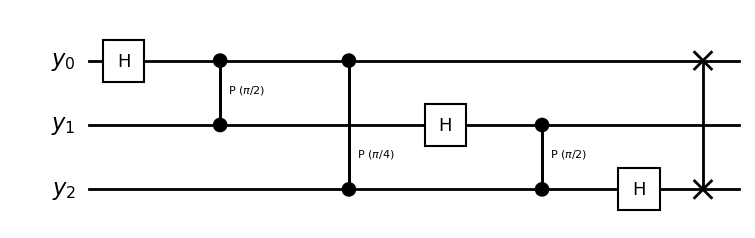

In [8]:
QuantumFourierTransform(3).draw(output="mpl", style="bw")

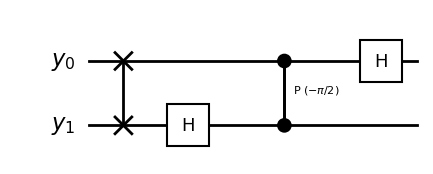

In [9]:
InverseQuantumFourierTransform(2).draw(output="mpl", style="bw")

In [10]:
def ParityFanOut(k, d):

    # misc definitions
    b_k, b_d = int(np.floor(np.log2(k))), int(np.floor(np.log2(d)))
    jumps_k, jumps_d = 1 << np.arange(b_k), 1 << np.arange(b_d)
    bits_k, bits_d = (k >> np.arange(b_k))%2, (d >> np.arange(b_d))%2

    # circuit
    qcontrol, qtarget = QuantumRegister(k, "x"), AncillaRegister(d, "y")
    pfo_circ = QuantumCircuit(qcontrol, qtarget, name=f"pfo")


    # compute parity
    for jump in jumps_k:
        for i in range(jump - 1, k - jump, 2 * jump):
            pfo_circ.cx(qcontrol[i], qcontrol[i + jump])

    for idx in np.where(bits_k)[0]:
        pfo_circ.cx(qcontrol[k - np.sum(1 << bits_k[:idx + 1])], qcontrol[- 1])

    # prepare for fan-out
    for jump in jumps_d:
        for i in range(d - 2 * jump, - 1, - 2 * jump):
            pfo_circ.cx(qtarget[i], qtarget[i + jump])

    for idx in np.where(bits_d)[0]:
        pfo_circ.cx(qtarget[0], qtarget[np.sum(1 << bits_d[:idx + 1]) - 1])

    # add parity
    pfo_circ.cx(qcontrol[-1], qtarget[0])

    # fan-out
    for idx in reversed(np.where(bits_d)[0]):
        pfo_circ.cx(qtarget[0], qtarget[np.sum(1 << bits_d[:idx + 1]) - 1])

    for jump in reversed(jumps_d):
        for i in range(d - 2 * jump, - 1, - 2 * jump):
            pfo_circ.cx(qtarget[i], qtarget[i + jump])

    # uncompute parity
    for idx in reversed(np.where(bits_k)[0]):
        pfo_circ.cx(qcontrol[k - np.sum(1 << bits_k[:idx+1])], qcontrol[-1])

    for jump in reversed(jumps_k):
        for i in range(jump-1, k-jump, 2*jump):
            pfo_circ.cx(qcontrol[i], qcontrol[i+jump])

    return pfo_circ

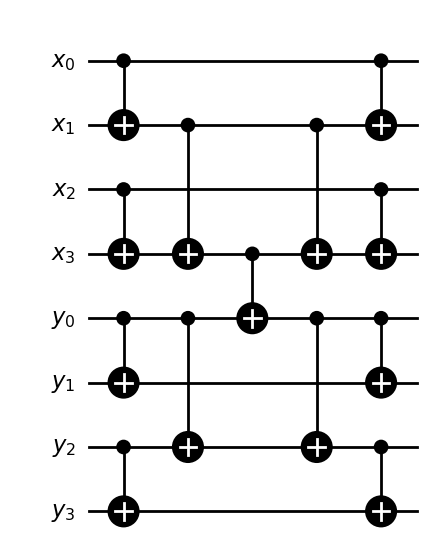

In [11]:
k, d = 4, 4
ParityFanOut(k, d).draw(output="mpl", style="bw")

In [12]:
def Phaser(angles):
    qtarget = AncillaRegister(angles.shape[0], "y")
    phaser_circ = QuantumCircuit(qtarget, name=f"phaser")

    for alpha, q in zip(angles, qtarget):#zip(np.mod(angles, 2 * np.pi), qtarget):
        if alpha != 0:
            phaser_circ.rz(alpha, q)

    return phaser_circ

In [13]:
def OracleThree(f):

    # get parameters
    phases, n, d = ModifiedWalshHadamard(f)
    print(phases)

    # defining the order & dropping the zero Walsh-Hadamard components. all this could be done on the fly too; doing it in pre-processing just for code-readability
    order = np.arange(1 << n)^(np.arange(1 << n) >> 1) # using the standard Gray code; this might change later
    codes = order[np.where(phases.T[0][order])[0]]
    qubits = [list(np.where(row)[0]) for row in ((codes^np.roll(codes, 1)).reshape(- 1, 1) >> np.arange(n))%2]

    ############

    qkeys = QuantumRegister(n, "x") # quantum registers for the bit configurations
    qvalues = QuantumRegister(d, "y") # quantum registers to digitize values
    qram_circ = QuantumCircuit(qkeys, qvalues, name=f"U(f, d)")

    ############

    qram_circ.barrier(label=f"Step 1")
    qram_circ.compose(Phaser(np.pi * (1 - (1 << d)) / (1 << np.arange(1, d + 1))), qubits=qvalues, inplace=True)

    qram_circ.barrier(label=f"Step 2")
    qram_circ.compose(QuantumFourierTransform(d).to_gate(), qubits=qvalues, inplace=True)

    for idx, [code, qubit_diff] in enumerate(zip(codes, qubits), start=1):
        qram_circ.barrier(label=f"Step 3/A, i = {idx}")
        qram_circ.compose(ParityFanOut(len(qubit_diff), d), qubits=qkeys[qubit_diff] + qvalues[:], inplace=True)
        qram_circ.barrier(label=f"Step 3/B, i = {idx}")
        qram_circ.compose(Phaser(phases[code]), qubits=qvalues, inplace=True)

    qram_circ.barrier(label=f"Step 4")
    last_diff = (codes[-1] >> np.arange(n))%2
    qram_circ.compose(ParityFanOut(np.sum(last_diff), d), qubits=qkeys[list(np.where(last_diff)[0])] + qvalues[:], inplace=True)

    qram_circ.barrier(label=f"Step 5")
    qram_circ.compose(InverseQuantumFourierTransform(d).to_gate(), qubits=qvalues, inplace=True)

    qram_circ.barrier(label=f"Step 6")
    qram_circ.compose(Phaser(- np.pi * (1 - (1 << d)) / (1 << np.arange(1, d + 1))), qubits=qvalues, inplace=True)

    return qram_circ

# Testing

In [14]:
#n, d = 3, 2

f = np.array([1, -2, 0, -1])
#f = [1, 3, 4, 0, 2, - 4, - 3, 1]

In [15]:
_, n, d = ModifiedWalshHadamard(f)
qkeys, qvalues = QuantumRegister(n, "x"), QuantumRegister(d, "y")
testing_circ = QuantumCircuit(qkeys, qvalues, name=f"O3")
#testing_circ.h(qkeys)
testing_circ.compose(OracleThree(f), qubits=qkeys[:] + qvalues[:], inplace=True)

[[-1.57079633 -0.78539816]
 [ 3.14159265  1.57079633]
 [ 0.          0.        ]
 [ 1.57079633  0.78539816]]


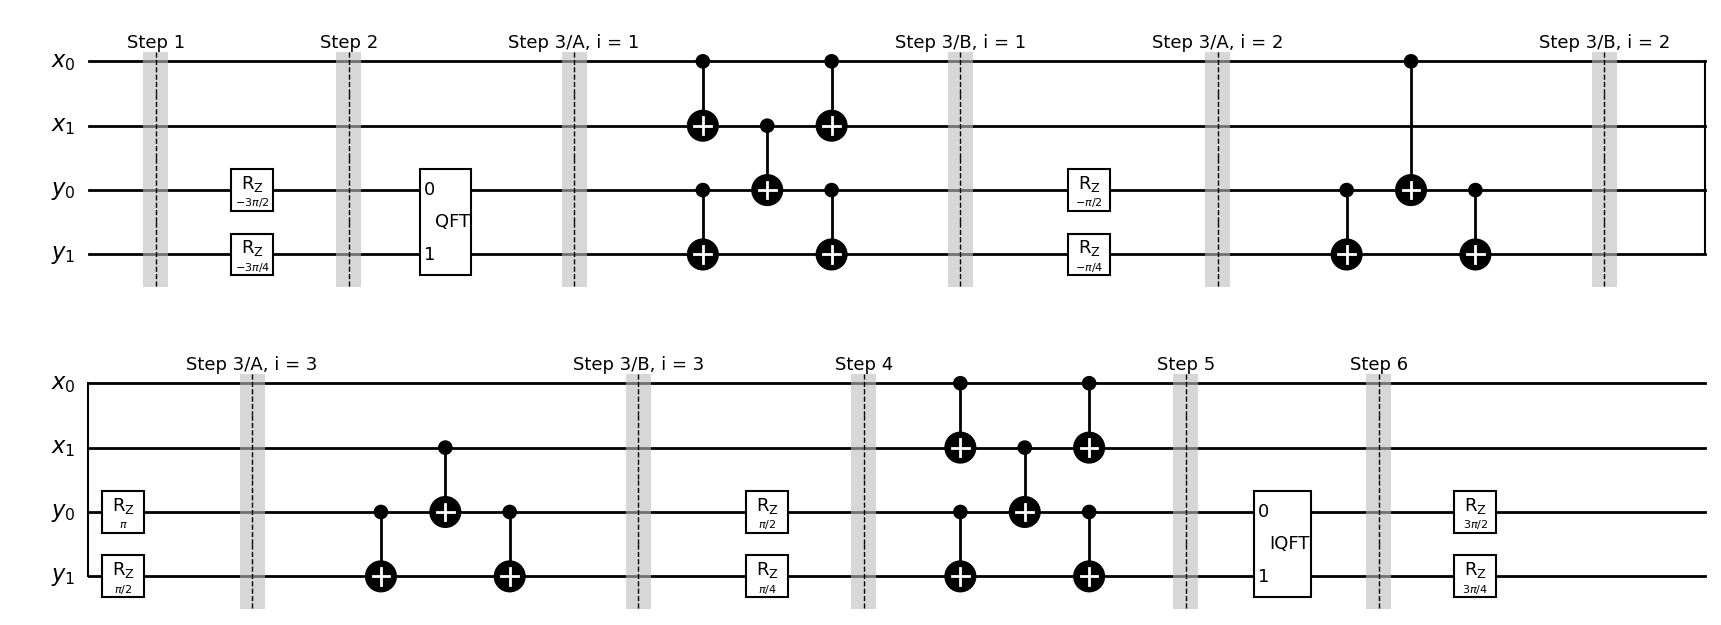

In [16]:
testing_circ.draw(output="mpl", style="bw")

In [17]:
results = pd.DataFrame(columns=["x", "ancilla", "f(x)", "value", "diff", "probability"])
distribution = Statevector(testing_circ).probabilities()
order = sorted([i for i in range(1 << (n + d))], key=lambda x: x%(1 << n))
for idx in order:
    if np.round(distribution[idx], 4) != 0:
        conf = "".join([str(b) for b in (idx >> np.arange(n + d + 1))%2])
        x, anc, fx, value, prob = conf[:n], conf[n:-1], f[idx%(1 << n)], (((idx >> np.arange(n, n + d))%2)@(1 << np.arange(d - 1, - 1, -1)) + (1 << (d - 1)))%(1 << d) - (1 << (d - 1)), distribution[idx]
        results.loc[len(results.index)] = [x, anc, fx, value, fx - value, prob]
results = results.style.hide(axis="index")
results

x,ancilla,f(x),value,diff,probability
00,01,1,1,0,1.000000
